In [1]:
import numpy as np
import pandas as pd
from utils.model_training import prepare_model_features, train_basic_cat_model, train_basic_LR_model
from sklearn.model_selection import train_test_split
import seaborn as sns



In [2]:
df = pd.read_csv(
    "./data/processed/stop-and-frisk.csv",
    parse_dates=["STOP_FRISK_DATE"],  
)
# df.info()

In [3]:
X, y = prepare_model_features(df)
assert not X.isnull().any().any(), "Null values remain in features"

In [ ]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("Train distribution:", y_train.value_counts(normalize=True), "\n")
print("Test distribution:", y_test.value_counts(normalize=True))

Train distribution: OFFICER_USED_FORCE
False    0.748507
True     0.251493
Name: proportion, dtype: float64 

Test distribution: OFFICER_USED_FORCE
False    0.748501
True     0.251499
Name: proportion, dtype: float64
[[4928 3313]
 [1090 1679]]
              precision    recall  f1-score   support

       False       0.82      0.60      0.69      8241
        True       0.34      0.61      0.43      2769

    accuracy                           0.60     11010
   macro avg       0.58      0.60      0.56     11010
weighted avg       0.70      0.60      0.63     11010



# Unsupervised placeholder

In [ ]:
X.columns

Index(['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT', 'HOUR_OF_DAY',
       'BOROUGH_FORCE_RATE', 'NEIGHBORHOOD_FORCE_RATE',
       'SUSPECT_RACE_DESCRIPTION_ASIAN / PACIFIC ISLANDER',
       'SUSPECT_RACE_DESCRIPTION_BLACK',
       'SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC',
       'SUSPECT_RACE_DESCRIPTION_MIDDLE EASTERN/SOUTHWEST ASIAN',
       'SUSPECT_RACE_DESCRIPTION_WHITE',
       'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC', 'SUSPECT_SEX_MALE',
       'STOP_WAS_INITIATED_Based on Radio Run',
       'STOP_WAS_INITIATED_Based on Self Initiated',
       'OFFICER_EXPERIENCE_senior', 'AGE_GROUP_teen', 'AGE_GROUP_young_adult',
       'AGE_GROUP_adult', 'AGE_GROUP_senior', 'OFFICER_IN_UNIFORM_FLAG',
       'IS_NIGHT', 'IS_WEEKEND', 'IS_CHILD',
       'SUSPECTED_CRIME_DESCRIPTION_ENCODED',
       'STOP_LOCATION_BORO_NAME_ENCODED', 'NEIGHBORHOOD_ENCODED'],
      dtype='object')

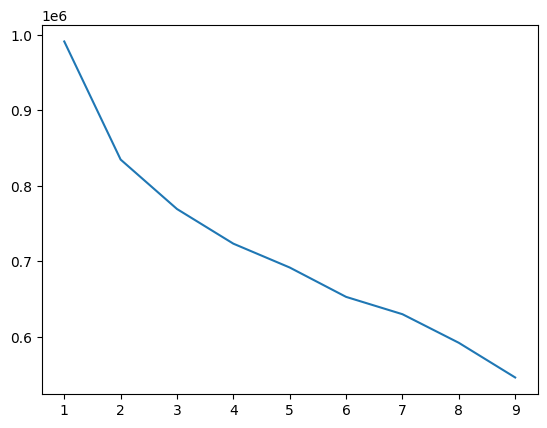

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Todo: move to EDA

# Focus on demographic features
# demo_features = ['SUSPECT_REPORTED_AGE', 'SUSPECT_HEIGHT',
#                 'NEIGHBORHOOD_ENCODED', 'SUSPECT_RACE_DESCRIPTION_ENCODED']

PCA_features = [
    "SUSPECT_REPORTED_AGE",
    "SUSPECT_HEIGHT",
    "BOROUGH_FORCE_RATE",  # More policy-relevant than neighborhood
    "STOP_WAS_INITIATED_Based on Self Initiated",  # Key behavioral marker
    # 'SUSPECT_RACE_DESCRIPTION_BLACK',
]

# Primary clustering features
primary_features = [
    "SUSPECTED_CRIME_DESCRIPTION_ENCODED",
    "NEIGHBORHOOD_ENCODED" "STOP_WAS_INITIATED_Based on Self Initiated",
    "BOROUGH_FORCE_RATE",
    "NEIGHBORHOOD_FORCE_RATE",
    "STOP_LOCATION_BORO_NAME_ENCODED",
]

# Secondary features to add
secondary_features = [
    "SUSPECT_SEX_MALE",
    "OFFICER_EXPERIENCE_senior",
    "IS_NIGHT",
    "IS_WEEKEND",
]

# Recommended starting set (combine primary + secondary)
recommended_features = [
    "SUSPECT_REPORTED_AGE",
    "HOUR_OF_DAY",
    "BOROUGH_FORCE_RATE",
    "SUSPECTED_CRIME_DESCRIPTION_ENCODED",
    "NEIGHBORHOOD_ENCODED",
    "SUSPECT_SEX_MALE",
    "OFFICER_EXPERIENCE_senior",
    "IS_NIGHT",
    "IS_WEEKEND",
]

shap_features = [
    "SUSPECTED_CRIME_DESCRIPTION_ENCODED",
    "SUSPECT_REPORTED_AGE",
    "NEIGHBORHOOD_ENCODED",
    "HOUR_OF_DAY",
    "NEIGHBORHOOD_FORCE_RATE",
    "STOP_WAS_INITIATED_Based on Self Initiated",
    "SUSPECT_HEIGHT",
    "OFFICER_EXPERIENCE_senior",
    "STOP_WAS_INITIATED_Based on Radio Run",
    "BOROUGH_FORCE_RATE",
    "STOP_LOCATION_BORO_NAME_ENCODED",
    "SUSPECT_SEX_MALE",
    "SUSPECT_RACE_DESCRIPTION_BLACK",
    "AGE_GROUP_young_adult",
    "SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC",
    "OFFICER_IN_UNIFORM_FLAG",
    "SUSPECT_RACE_DESCRIPTION_WHITE",
    "AGE_GROUP_adult",
]

PCA_features = shap_features

scaler = StandardScaler()
X_scaled_selected_features = scaler.fit_transform(X[PCA_features])
X_full_scaled = scaler.fit_transform(X)
# Elbow method to find optimal clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled_selected_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve to choose K
plt.plot(range(1, 10), inertia)

In [ ]:
kmeans = KMeans(n_clusters=5).fit(X_scaled_selected_features)
kmeans_full = KMeans(n_clusters=5).fit(X_full_scaled)

# Create new DF with clusters
cluster_df = pd.DataFrame(X_scaled_selected_features, columns=PCA_features)
cluster_df['Cluster'] = kmeans.labels_  
cluster_df_full = pd.DataFrame(X_full_scaled)
cluster_df_full['Cluster'] = kmeans.labels_  

# Ensure that the distribution between clusters is reasonably balanced
print(pd.Series(kmeans.labels_).value_counts())
print(pd.Series(kmeans_full.labels_).value_counts())

2    16076
4    11817
3    11563
1    11540
0     4051
Name: count, dtype: int64
2    16880
1    14763
0    11722
4    10682
3     1000
Name: count, dtype: int64


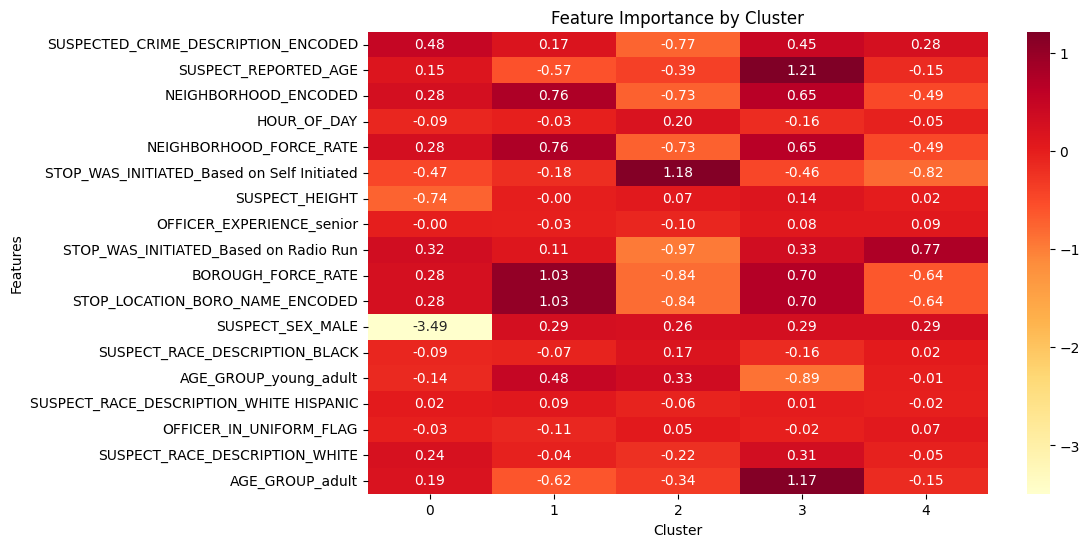

In [ ]:
# Calculate mean values per cluster
def show_cluster_heatmap(df):
    cluster_means = df.groupby('Cluster').mean()

    plt.figure(figsize=(10,6))
    sns.heatmap(cluster_means.T, 
                cmap='YlOrRd', 
                annot=True, 
                fmt='.2f')
    plt.title('Feature Importance by Cluster')
    plt.ylabel('Features')
    plt.xlabel('Cluster')
show_cluster_heatmap(cluster_df)

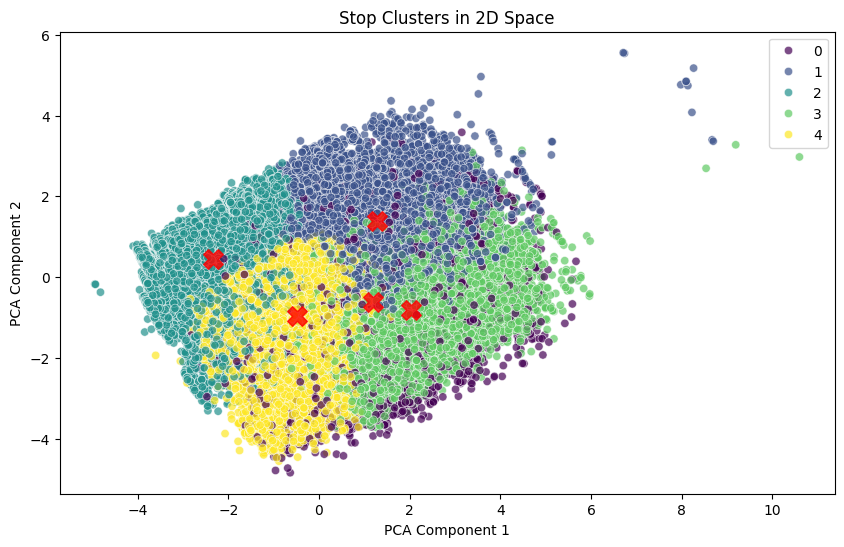

In [ ]:
from sklearn.decomposition import PCA
def plot_PCA(X):
    # Reduce to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot with cluster labels
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], 
                    hue=kmeans.labels_, 
                    palette='viridis',
                    alpha=0.7)
    plt.title('Stop Clusters in 2D Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Add cluster centers
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:,0], centers_pca[:,1], 
                c='red', s=200, alpha=0.8, marker='X')
plot_PCA(X_scaled_selected_features)

In [ ]:
# Temp
# Calculate racial composition per cluster
post_cluster_df = pd.DataFrame(X)
post_cluster_df['Cluster'] = kmeans.labels_  
# post_cluster_df.columns
race_pcts = (post_cluster_df.groupby('Cluster')['SUSPECT_RACE_DESCRIPTION_BLACK']
             .mean()
             .sort_values(ascending=False))

print(f"Cluster Racial Composition:\n{race_pcts}")

Cluster Racial Composition:
Cluster
2    0.684436
4    0.610307
1    0.565251
0    0.553444
3    0.519588
Name: SUSPECT_RACE_DESCRIPTION_BLACK, dtype: float64


In [ ]:
# Compare variance explained by your 4 features vs. full dataset
pca_full = PCA().fit(X_full_scaled)  
pca_subset = PCA().fit(X_scaled_selected_features)
print("Full dataset variance:", pca_full.explained_variance_ratio_.cumsum()[:4])
print("Your features' variance:", pca_subset.explained_variance_ratio_.cumsum())

Full dataset variance: [0.1689348  0.27119921 0.35104552 0.42070385]
Your features' variance: [0.22953833 0.34353198 0.43586521 0.51806308 0.58310996 0.64303981
 0.70125773 0.75590589 0.80700311 0.85113069 0.88735539 0.92188158
 0.95518945 0.97656086 0.98934937 1.         1.         1.        ]


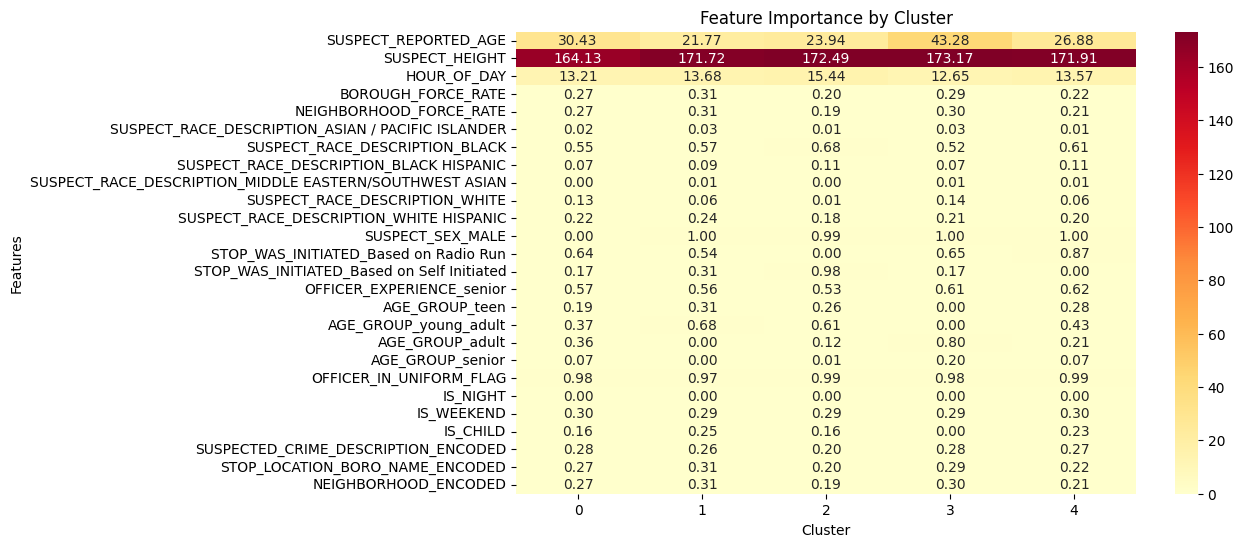

In [ ]:
show_cluster_heatmap(post_cluster_df)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Your top SHAP features
top_features = [
    'SUSPECTED_CRIME_DESCRIPTION_ENCODED',
    'SUSPECT_REPORTED_AGE', 
    'NEIGHBORHOOD_ENCODED',
    'HOUR_OF_DAY',
    'NEIGHBORHOOD_FORCE_RATE',
    'STOP_WAS_INITIATED_Based on Self Initiated',
    'SUSPECT_HEIGHT',
    'OFFICER_EXPERIENCE_senior',
    'STOP_WAS_INITIATED_Based on Radio Run',
    'BOROUGH_FORCE_RATE',
    'STOP_LOCATION_BORO_NAME_ENCODED',
    'SUSPECT_SEX_MALE'
]

# Demographic features for bias analysis
demographic_features = [
    'SUSPECT_RACE_DESCRIPTION_BLACK',
    'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC',
    'SUSPECT_RACE_DESCRIPTION_WHITE',
    'SUSPECT_SEX_MALE',
    'SUSPECT_REPORTED_AGE'
]

def perform_pca_analysis(df, features, n_components=None):
    """
    Perform PCA analysis with comprehensive output
    """
    # Handle missing values
    df_clean = df[features].fillna(df[features].median())
    
    # Determine number of components if not specified
    if n_components is None:
        n_components = min(len(features), 10)
    
    # Create PCA pipeline with scaling
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])
    
    # Fit and transform
    pca_components = pca_pipeline.fit_transform(df_clean)
    pca = pca_pipeline.named_steps['pca']
    
    # Create results dataframe
    pca_df = pd.DataFrame(
        pca_components, 
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    return pca_df, pca, pca_pipeline

def analyze_component_loadings(pca, features, n_components=5):
    """
    Analyze and visualize PCA loadings
    """
    # Get loadings (components)
    loadings = pca.components_[:n_components]
    
    # Create loadings dataframe
    loadings_df = pd.DataFrame(
        loadings.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=features
    )
    
    print("Top Feature Loadings by Component:")
    print("=" * 50)
    
    for i in range(n_components):
        pc_name = f'PC{i+1}'
        print(f"\n{pc_name} (Variance Explained: {pca.explained_variance_ratio_[i]:.3f}):")
        
        # Get top positive and negative loadings
        pc_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
        print("Top contributing features:")
        for feature, loading in pc_loadings.head(5).items():
            actual_loading = loadings_df.loc[feature, pc_name]
            print(f"  {feature}: {actual_loading:.3f}")
    
    return loadings_df

def analyze_demographic_correlations(pca_df, df, demographic_features):
    """
    Analyze how PCA components correlate with demographic variables
    """
    print("\nDemographic Correlations with Principal Components:")
    print("=" * 60)
    
    correlations = {}
    
    for demo_feature in demographic_features:
        if demo_feature in df.columns:
            correlations[demo_feature] = {}
            
            for pc in pca_df.columns:
                corr, p_value = pearsonr(pca_df[pc], df[demo_feature])
                correlations[demo_feature][pc] = {'correlation': corr, 'p_value': p_value}
                
                if abs(corr) > 0.1:  # Only show meaningful correlations
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    print(f"{demo_feature} vs {pc}: r={corr:.3f} {significance}")
    
    return correlations

def plot_pca_results(pca, pca_df, loadings_df):
    """
    Create visualizations for PCA results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Explained variance
    axes[0,0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                  pca.explained_variance_ratio_)
    axes[0,0].set_xlabel('Principal Component')
    axes[0,0].set_ylabel('Explained Variance Ratio')
    axes[0,0].set_title('Explained Variance by Component')
    
    # 2. Cumulative explained variance
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    axes[0,1].plot(range(1, len(cumvar) + 1), cumvar, 'bo-')
    axes[0,1].axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    axes[0,1].set_title('Cumulative Explained Variance')
    axes[0,1].legend()
    
    # 3. PC1 vs PC2 scatter
    axes[1,0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)
    axes[1,0].set_xlabel('PC1')
    axes[1,0].set_ylabel('PC2')
    axes[1,0].set_title('PC1 vs PC2 Scatter Plot')
    
    # 4. Loadings heatmap (top 5 components)
    n_components_plot = min(5, loadings_df.shape[1])
    sns.heatmap(loadings_df.iloc[:, :n_components_plot], 
                annot=True, cmap='RdBu_r', center=0, ax=axes[1,1])
    axes[1,1].set_title('Feature Loadings Heatmap')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def run_complete_pca_analysis(df, top_features=PCA_features):
    """
    Run complete PCA analysis workflow
    """
    print("Starting PCA Analysis on Stop-and-Frisk Dataset")
    print("=" * 60)
    
    # Perform PCA
    pca_df, pca, pca_pipeline = perform_pca_analysis(df, top_features)
    
    print(f"PCA completed. Shape: {pca_df.shape}")
    print(f"Total variance explained by {len(pca_df.columns)} components: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Analyze loadings
    loadings_df = analyze_component_loadings(pca, top_features)
    
    # Analyze demographic correlations
    demo_correlations = analyze_demographic_correlations(pca_df, df, demographic_features)
    
    # Create visualizations
    plot_pca_results(pca, pca_df, loadings_df)
    
    return pca_df, pca, loadings_df, demo_correlations

# Usage example:
# Assuming your dataframe is called 'df'
# pca_results, pca_model, loadings, correlations = run_complete_pca_analysis(df)

# Additional analysis: Find stops with extreme PC scores
def find_extreme_cases(pca_df, df, percentile=95):
    """
    Find cases with extreme principal component scores
    """
    print(f"\nExreme Cases (>{percentile}th percentile):")
    print("=" * 40)
    
    for pc in pca_df.columns[:3]:  # Top 3 components
        threshold = np.percentile(pca_df[pc], percentile)
        extreme_indices = pca_df[pca_df[pc] > threshold].index
        
        print(f"\n{pc} extreme cases ({len(extreme_indices)} cases):")
        if len(extreme_indices) > 0:
            # Show characteristics of extreme cases
            extreme_demographics = df.loc[extreme_indices, demographic_features].mean()
            print("Average demographics of extreme cases:")
            for demo, value in extreme_demographics.items():
                print(f"  {demo}: {value:.3f}")

# find_extreme_cases(pca_results, df)

Starting PCA Analysis on Stop-and-Frisk Dataset
PCA completed. Shape: (55047, 10)
Total variance explained by 10 components: 0.851
Top Feature Loadings by Component:

PC1 (Variance Explained: 0.230):
Top contributing features:
  NEIGHBORHOOD_ENCODED: 0.411
  NEIGHBORHOOD_FORCE_RATE: 0.411
  BOROUGH_FORCE_RATE: 0.405
  STOP_LOCATION_BORO_NAME_ENCODED: 0.405
  STOP_WAS_INITIATED_Based on Self Initiated: -0.299

PC2 (Variance Explained: 0.114):
Top contributing features:
  AGE_GROUP_adult: -0.383
  SUSPECT_REPORTED_AGE: -0.325
  AGE_GROUP_young_adult: 0.323
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.287
  STOP_WAS_INITIATED_Based on Self Initiated: 0.283

PC3 (Variance Explained: 0.092):
Top contributing features:
  SUSPECT_RACE_DESCRIPTION_BLACK: -0.580
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.567
  AGE_GROUP_adult: -0.300
  AGE_GROUP_young_adult: 0.297
  SUSPECT_HEIGHT: -0.262

PC4 (Variance Explained: 0.082):
Top contributing features:
  STOP_WAS_INITIATED_Based on Radio Run: -0.486
  STO

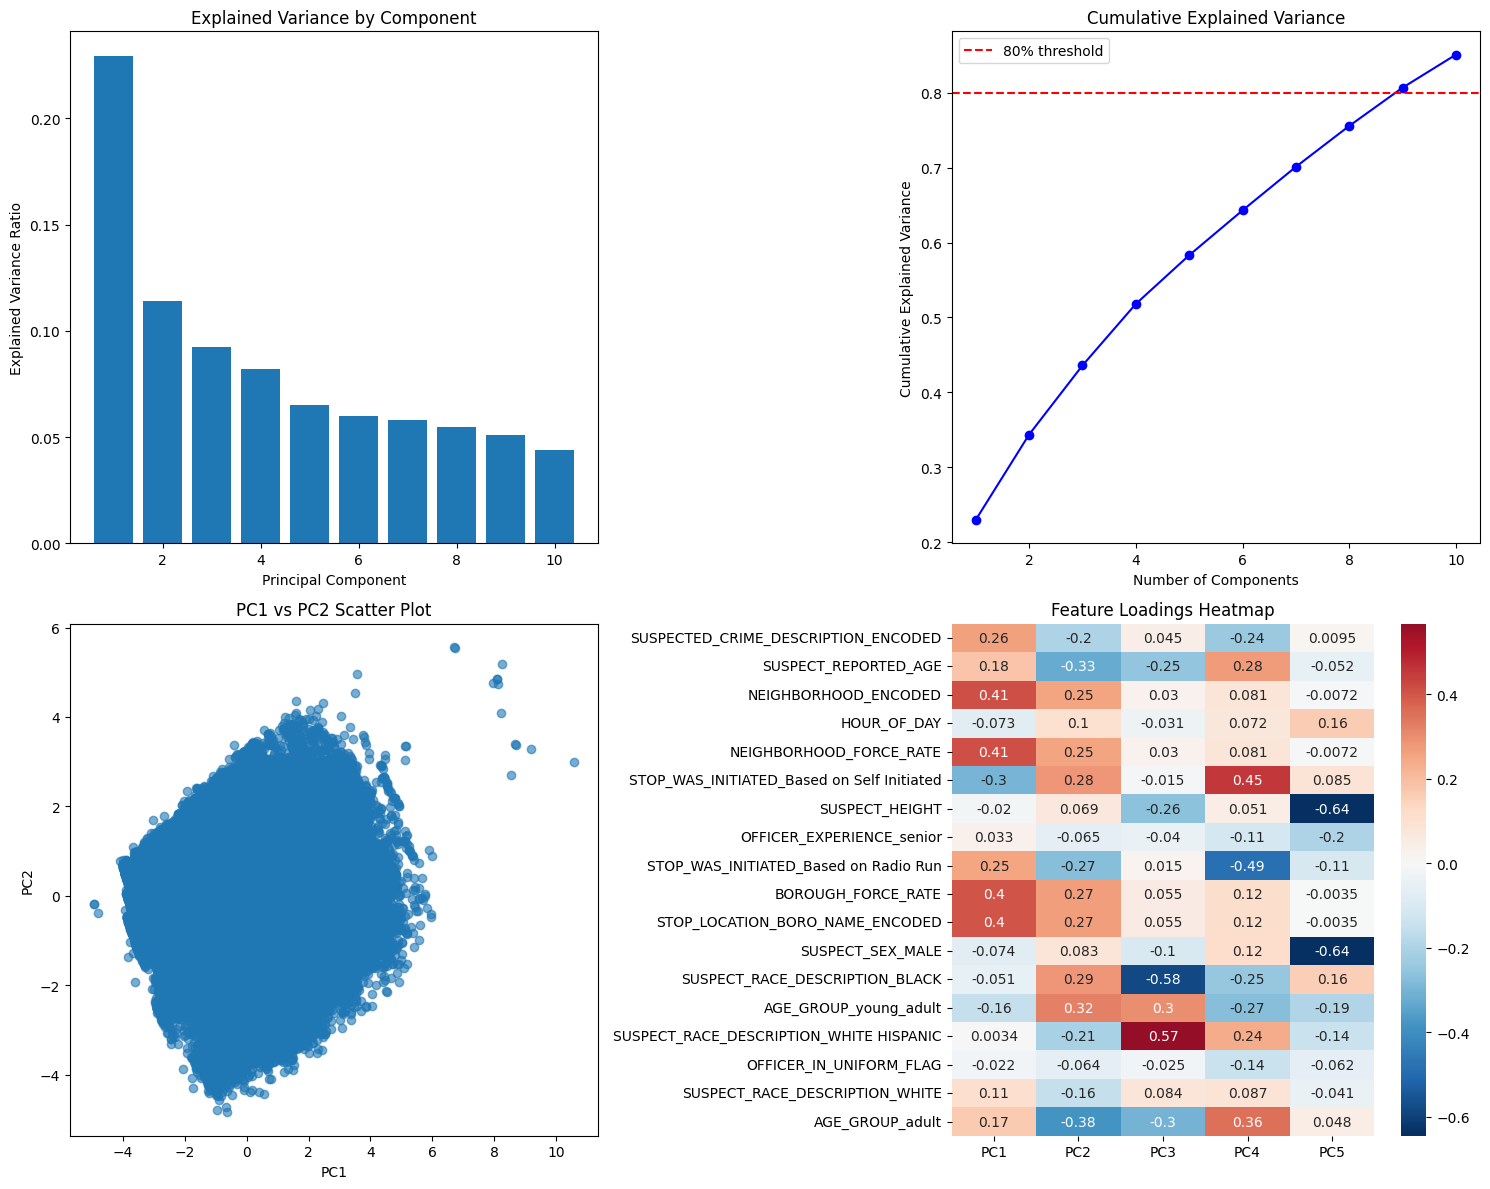

In [ ]:
pca_results, pca_model, loadings, correlations = run_complete_pca_analysis(X)

# PC1, Location/Neighborhood, negative self initiated indicates radio/witness origin
# PC2, black males in targeted in a police initiated stop
# PC3, Young hispanic males, filtering out black males
# PC4, police initated stops of adults 
# PC5, shorter individuals and women, with small effect on time of day

In [ ]:
find_extreme_cases(pca_results, X)
# demographic_features


Exreme Cases (>95th percentile):

PC1 extreme cases (2753 cases):
Average demographics of extreme cases:
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.481
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.199
  SUSPECT_RACE_DESCRIPTION_WHITE: 0.206
  SUSPECT_SEX_MALE: 0.845
  SUSPECT_REPORTED_AGE: 39.462

PC2 extreme cases (2753 cases):
Average demographics of extreme cases:
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.919
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.026
  SUSPECT_RACE_DESCRIPTION_WHITE: 0.006
  SUSPECT_SEX_MALE: 0.973
  SUSPECT_REPORTED_AGE: 22.173

PC3 extreme cases (2753 cases):
Average demographics of extreme cases:
  SUSPECT_RACE_DESCRIPTION_BLACK: 0.000
  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC: 0.999
  SUSPECT_RACE_DESCRIPTION_WHITE: 0.001
  SUSPECT_SEX_MALE: 0.818
  SUSPECT_REPORTED_AGE: 22.879


In [ ]:
pca_df = df.copy()
# pca_df['Cluster'] = kmeans.labels_  
pca_X, pca_y = prepare_model_features(pca_df)

clustered_X_train, clustered_y_train, clustered_X_test, clustered_y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
train_basic_LR_model(clustered_X_train, clustered_y_train, clustered_X_test, clustered_y_test)

/home/yao/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.